In [837]:
import numpy as np
import cv2
import kagglehub
import json
import os
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

path = kagglehub.dataset_download("humansintheloop/teeth-segmentation-on-dental-x-ray-images")

print("Path to dataset files:", path)

Path to dataset files: /home/mamusiaarusia/.cache/kagglehub/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images/versions/1


In [836]:
sources = {k: Path(path) / f'Teeth Segmentation {k}' for k in ['JSON', 'PNG']}

meta = {}
for p in sources.values():
    meta.update(json.loads((p / 'meta.json').read_text()))

images = [
    Image.open(img_path) 
    for p in sources.values() 
    for img_path in (p / 'd2' / 'img').glob('*')
]

images_np = [np.array(image) for image in images]

# kszalt zdjec: 1024 x (1024 - 2041) w zaleznosci od zdjecia

In [838]:
def to_fft(img):
    # cv2 musi miec float32 na wejsciu
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    return np.fft.fftshift(dft) # 0hz (srednia) na srodek

def from_fft(dft_shifted):
    f_ishift = np.fft.ifftshift(dft_shifted) # 0hz z powrotem do rogu
    img_back = cv2.idft(f_ishift) # odwrotna transformata
    mag = cv2.magnitude(img_back[:,:,0], img_back[:,:,1]) # amplituda (modul zespolonej)
    cv2.normalize(mag, mag, 0, 255, cv2.NORM_MINMAX) # zeby nie wywalilo wartosci w kosmos
    return np.uint8(mag)

def get_bandpass_mask(image, r_min = 0, r_max = np.inf):
    rows, cols, _ = image.shape
    crow, ccol = rows // 2, cols // 2
    
    y, x = np.ogrid[:rows, :cols]
    dist = np.sqrt((x - ccol)**2 + (y - crow)**2) # pitagoras od srodka
    
    mask = np.zeros((rows, cols, 2), np.float32) # 2 kanaly bo liczby zespolone
    mask[(dist >= r_min) & (dist <= r_max)] = 1 # przepuszczamy pasmo
    return image * mask
    
def apply_gaussian_hpf(fft_img, d0):
    h, w = fft_img.shape[:2]
    cy, cx = h // 2, w // 2
    
    y, x = np.ogrid[:h, :w]
    dist_sq = (x - cx)**2 + (y - cy)**2 # kwadrat odleglosci (optymalizacja)
    
    mask = 1 - np.exp(-dist_sq / (2 * d0**2)) # Wzor Gaussa HPF
    
    mask = np.dstack([mask, mask]) # klonujemy na 2 kanaly (Re+Im)
    return fft_img * mask

def apply_butterworth_hpf(fft_img, d0, n):
    h, w = fft_img.shape[:2]
    cy, cx = h // 2, w // 2
    
    y, x = np.ogrid[:h, :w]
    dist = np.sqrt((x - cx)**2 + (y - cy)**2) # odleglosc od srodka
    
    # Wzor Butterwortha HPF. Epsilon 1e-5 zeby nie dzielic przez 0
    # n=1 (miekkie), n=5 (ostre), d0=promien odciecia
    mask = 1 / (1 + (d0 / (dist + 1e-5))**(2 * n))
    
    mask = np.dstack([mask, mask]) # 2 kanaly dla fft
    return fft_img * mask

def thresholding(image: np.ndarray[int], /, n: int = None, custom_thresholds: np.ndarray = None) -> np.ndarray:
    if n is not None:
        thresholds = np.linspace(0, 255, num=n)
    elif custom_thresholds is not None:
        thresholds = custom_thresholds
    else:
        raise ValueError("Either n or custom_thresholds must be provided")

    for i in range(1, len(thresholds)):
        avg = (thresholds[i] + thresholds[i-1]) // 2
        image[(image < thresholds[i]) & (image > thresholds[i-1])] = avg

    return image

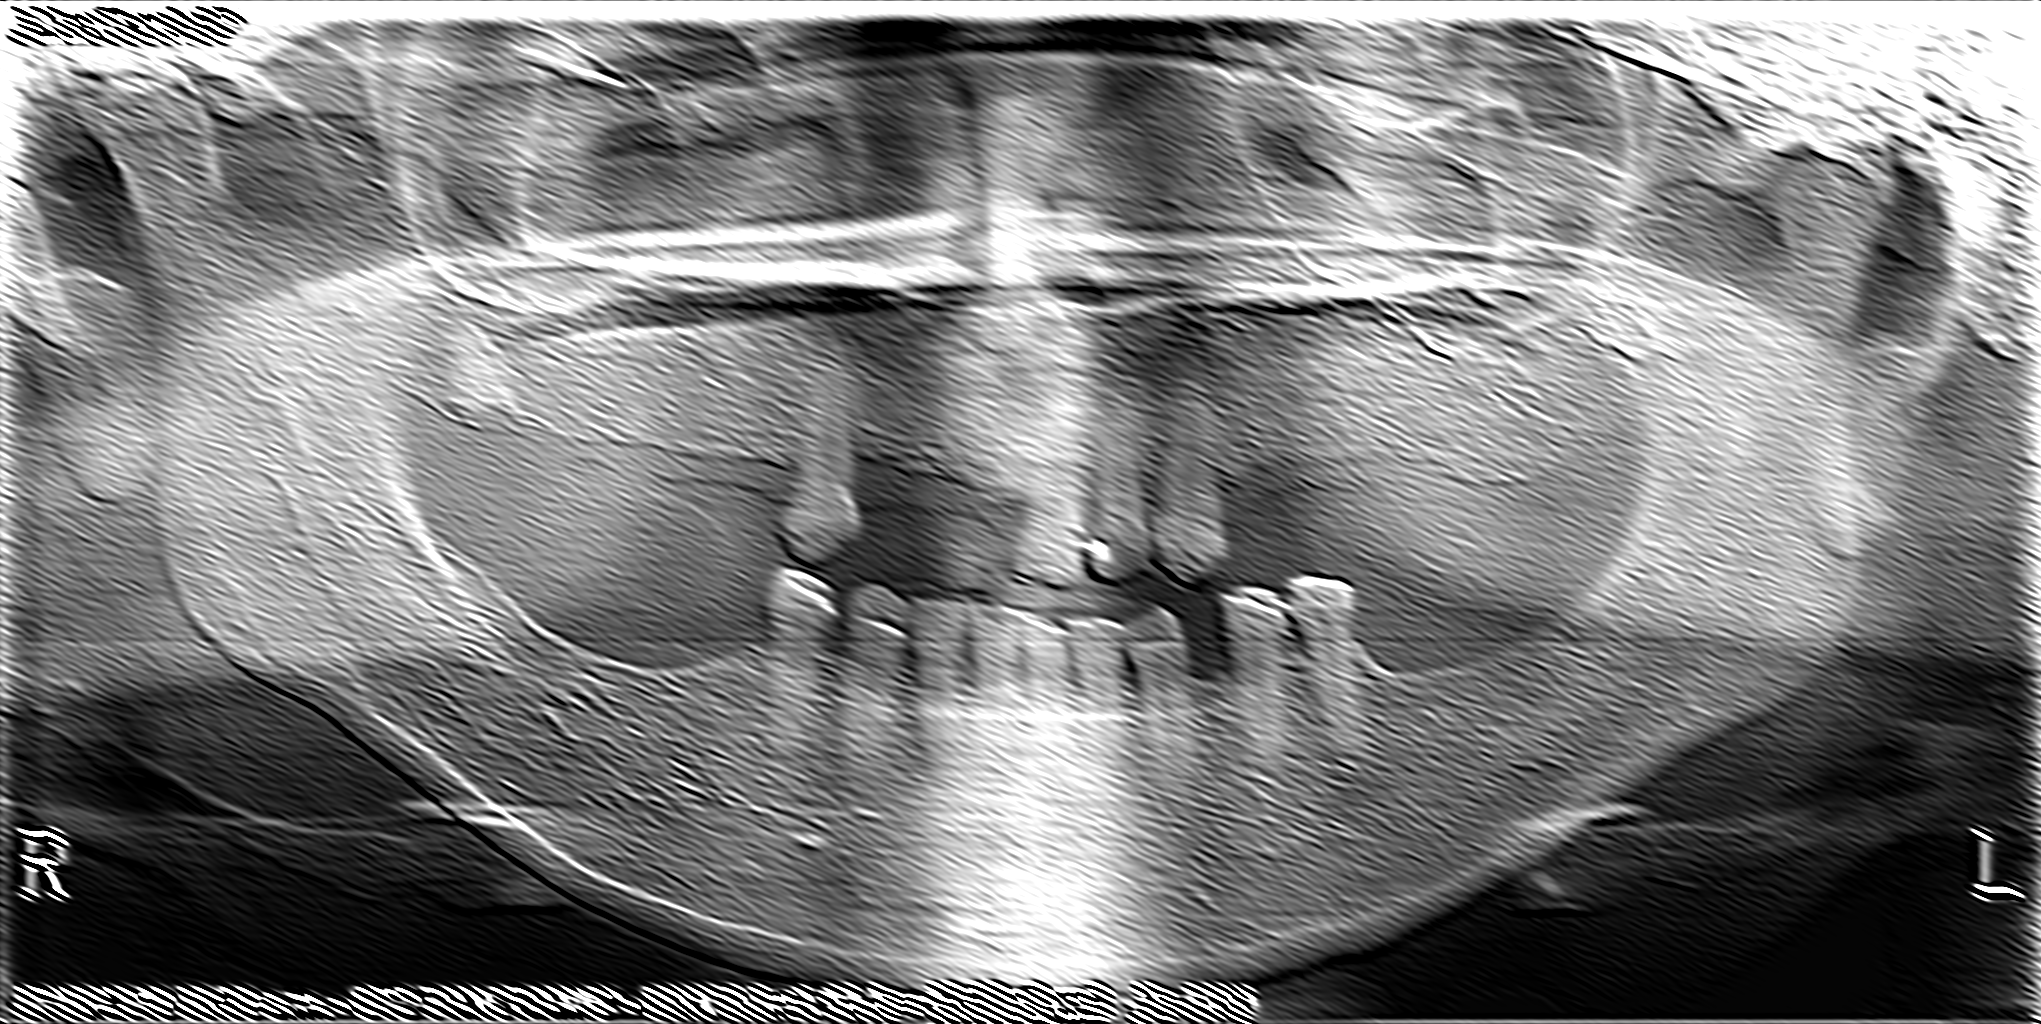

In [839]:
# dobrze byloby wyfiltrowac niepionowe rzeczy gaborem
# tj. Sa zeby lezacy w zbiorze danych, ale nimi ja sie nie przejmuje

image = images_np[0]

kernel_size = (50, 50)
sigma = 3
theta = 90
lambda_val = 7 # dlugosc fali
gamma = 0.5 # aspect ratio - 0 = kreska, 0.5 = jakas elipsa, 1.0 - okrag
psi = np.pi/3 # offset fazy - 0 = wykrywanie linii, pi/2 = Krawedzie, pi = Wykrywanie ciemnych linii na jasnym tle

# Gabor na pewno sie przyda
kernel = cv2.getGaborKernel(kernel_size, sigma, theta, lambda_val, gamma, psi, ktype=cv2.CV_32F)

filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)

Image.fromarray(filtered)

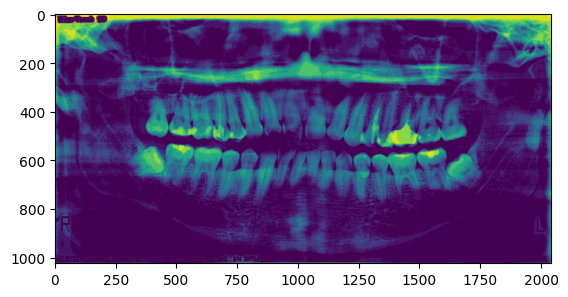

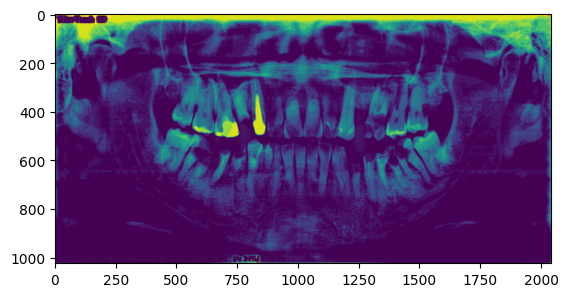

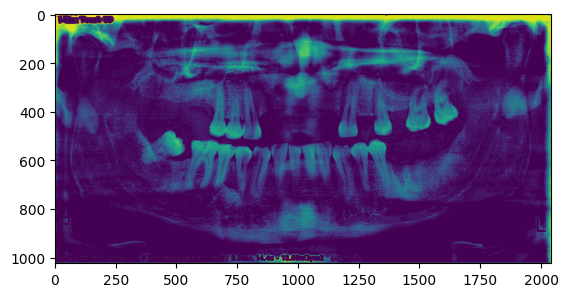

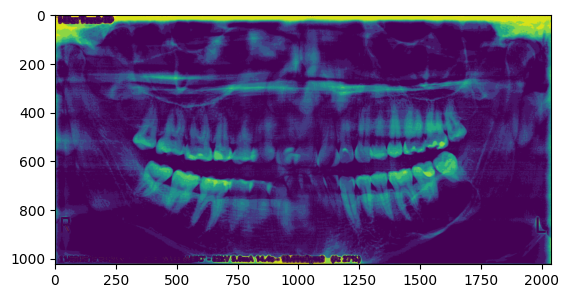

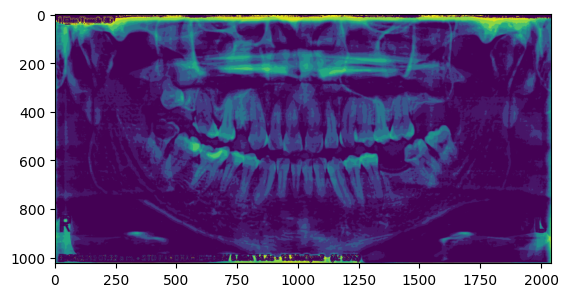

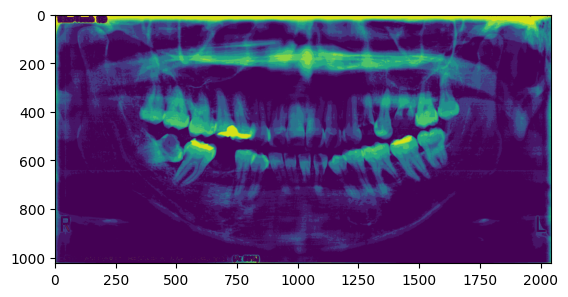

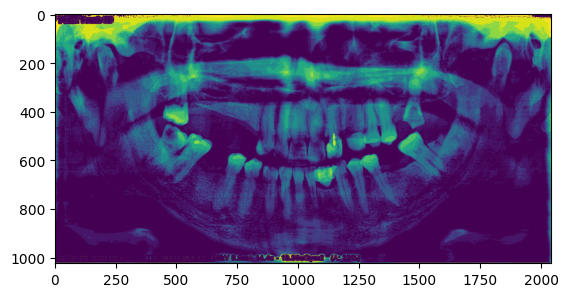

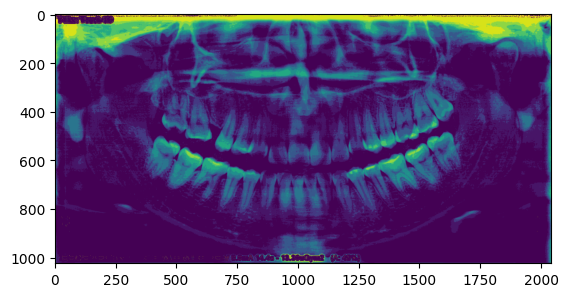

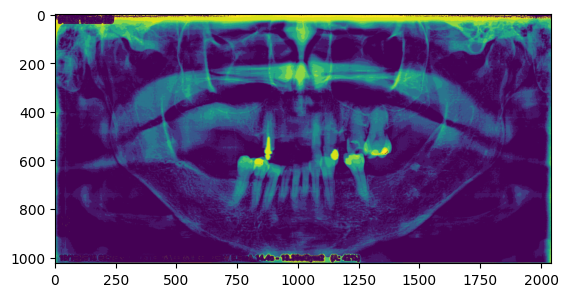

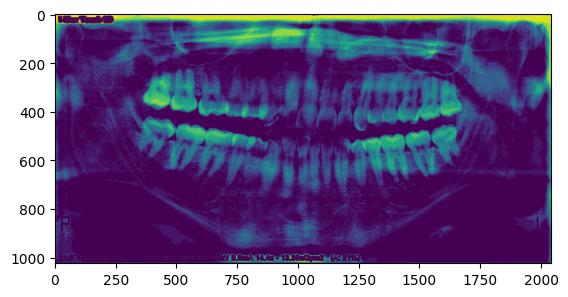

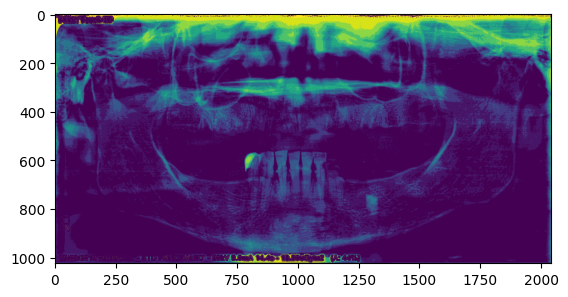

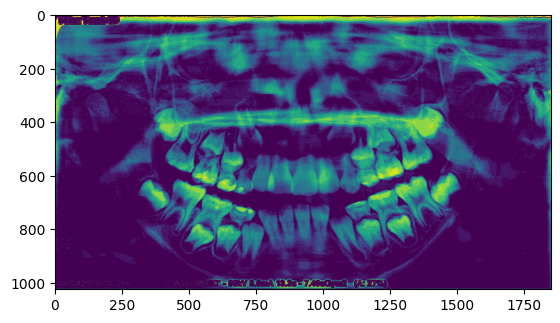

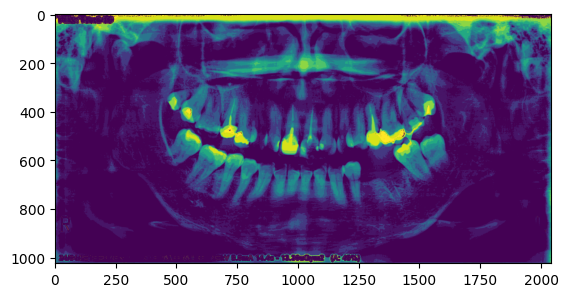

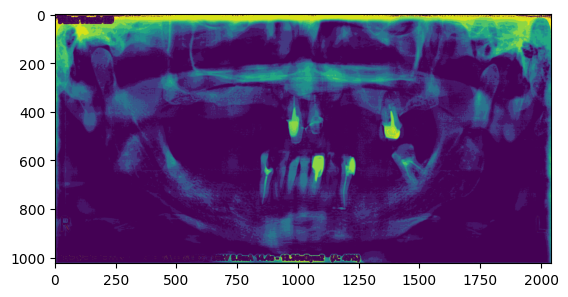

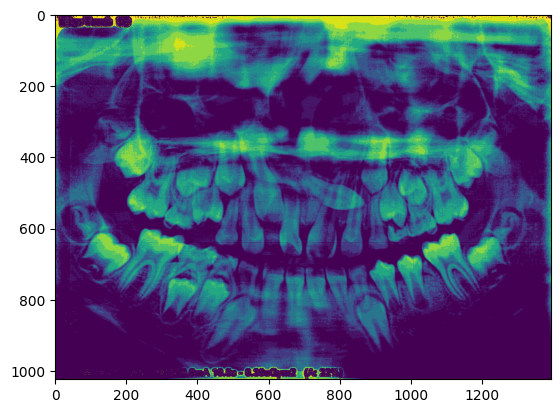

In [844]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (69, 185))

#* PLAYGROUND 
#! tutaj trzeba wywalic ta szczeke i taki jest caly cel
# image = images_np[61]

for i in np.arange(50, 65):
    image = images_np[i]
    # wywalic to cos z gory
    image[image >= 250] = 0.0 # usuwanie super jasnych napisow 
    image = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)

    # moze gauss dolno-przepustowy by tu wszedl
    # fourier_image = to_fft(image)
    # filtered_fourier = apply_gaussian_hpf(fourier_image, 2)
    # image = from_fft(filtered_fourier)

    gain = 5
    cutoff = 20

    image = image.astype(float) / 255.0

    image = 1 / (1 + np.exp(-gain * image))
    image = np.uint8(np.round(image * 255))

    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    image = np.uint8(np.clip(np.int16(image) - cutoff, 0, 255))
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    # floodfill - nie wiem czy to najlepszy pomysl wszystko na czarno moze zamienic
    # diff = 0
    # cv2.floodFill(image, None, seedPoint=(image.shape[0]//2, 3), newVal=0, loDiff=(diff,), upDiff=(diff,), flags=4)

    image = thresholding(image, n=10)

    img = Image.fromarray(image)
    plt.imshow(img)
    plt.show()

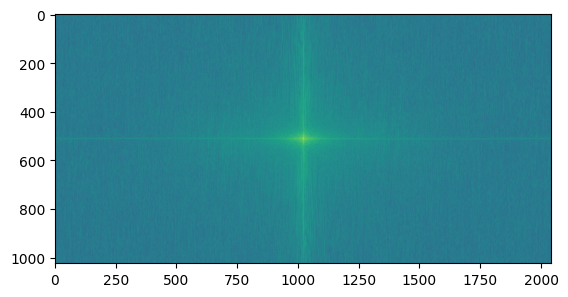

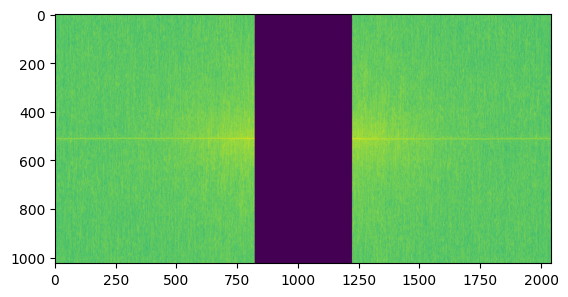

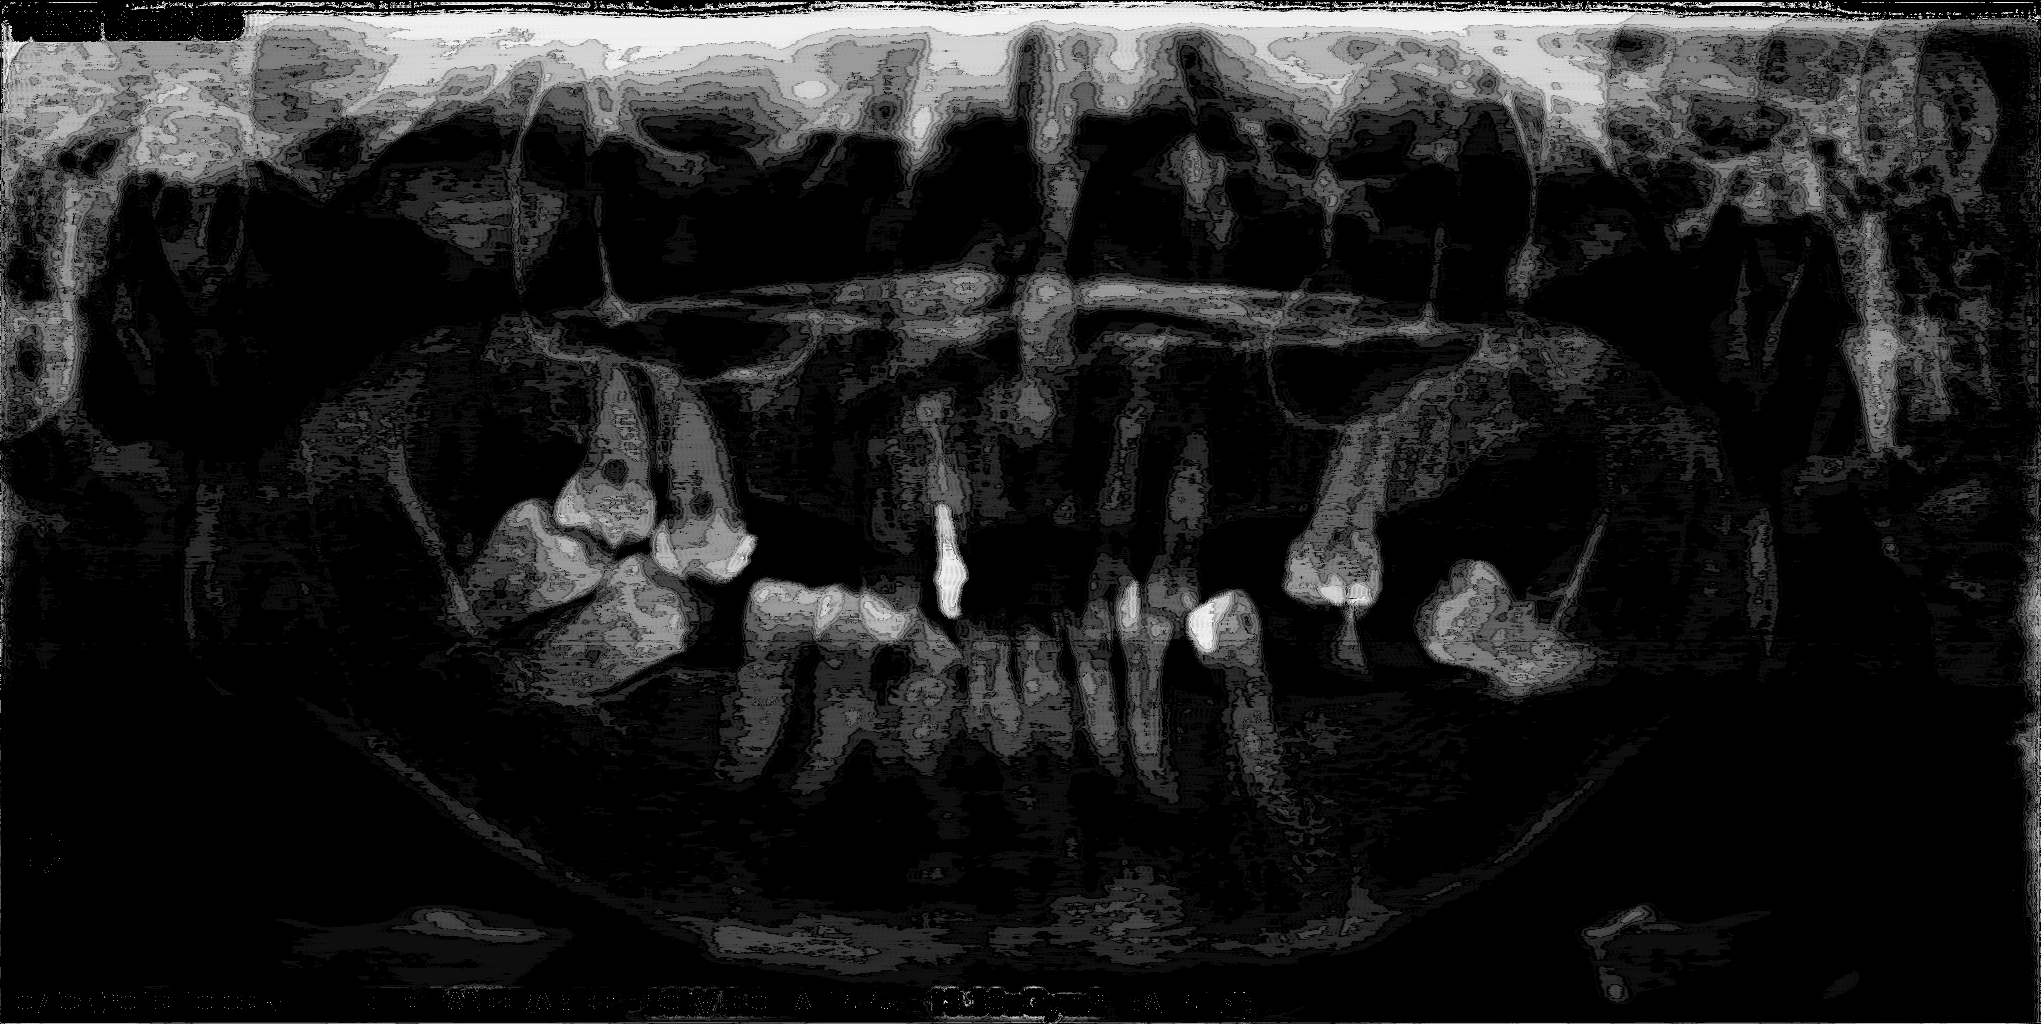

In [765]:
fourier = to_fft(image)
fourier_show = cv2.magnitude(fourier[:,:,0], fourier[:,:,1])
plt.imshow(np.log10(fourier_show + 1))
plt.show()
mask = np.ones_like(fourier)
mask[:, fourier.shape[1] // 2 - 200: fourier.shape[1] // 2 + 200] = 0
fourier_cut = fourier * mask
fourier_show = cv2.magnitude(fourier_cut[:,:,0], fourier_cut[:,:,1])
plt.imshow(np.log10(fourier_show + 1))
plt.show()
back = from_fft(fourier_cut)
Image.fromarray(np.uint8(np.clip((np.int16(image) - 5 * back), 0, 255)))

(array([1258989.,  256398.,  166396.,  116125.,   83816.,   37003.,
          57267.,   39155.,   31908.,   42927.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

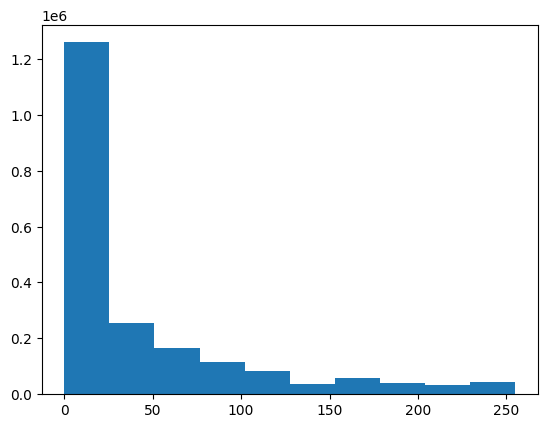

In [731]:
plt.hist(image.flatten())

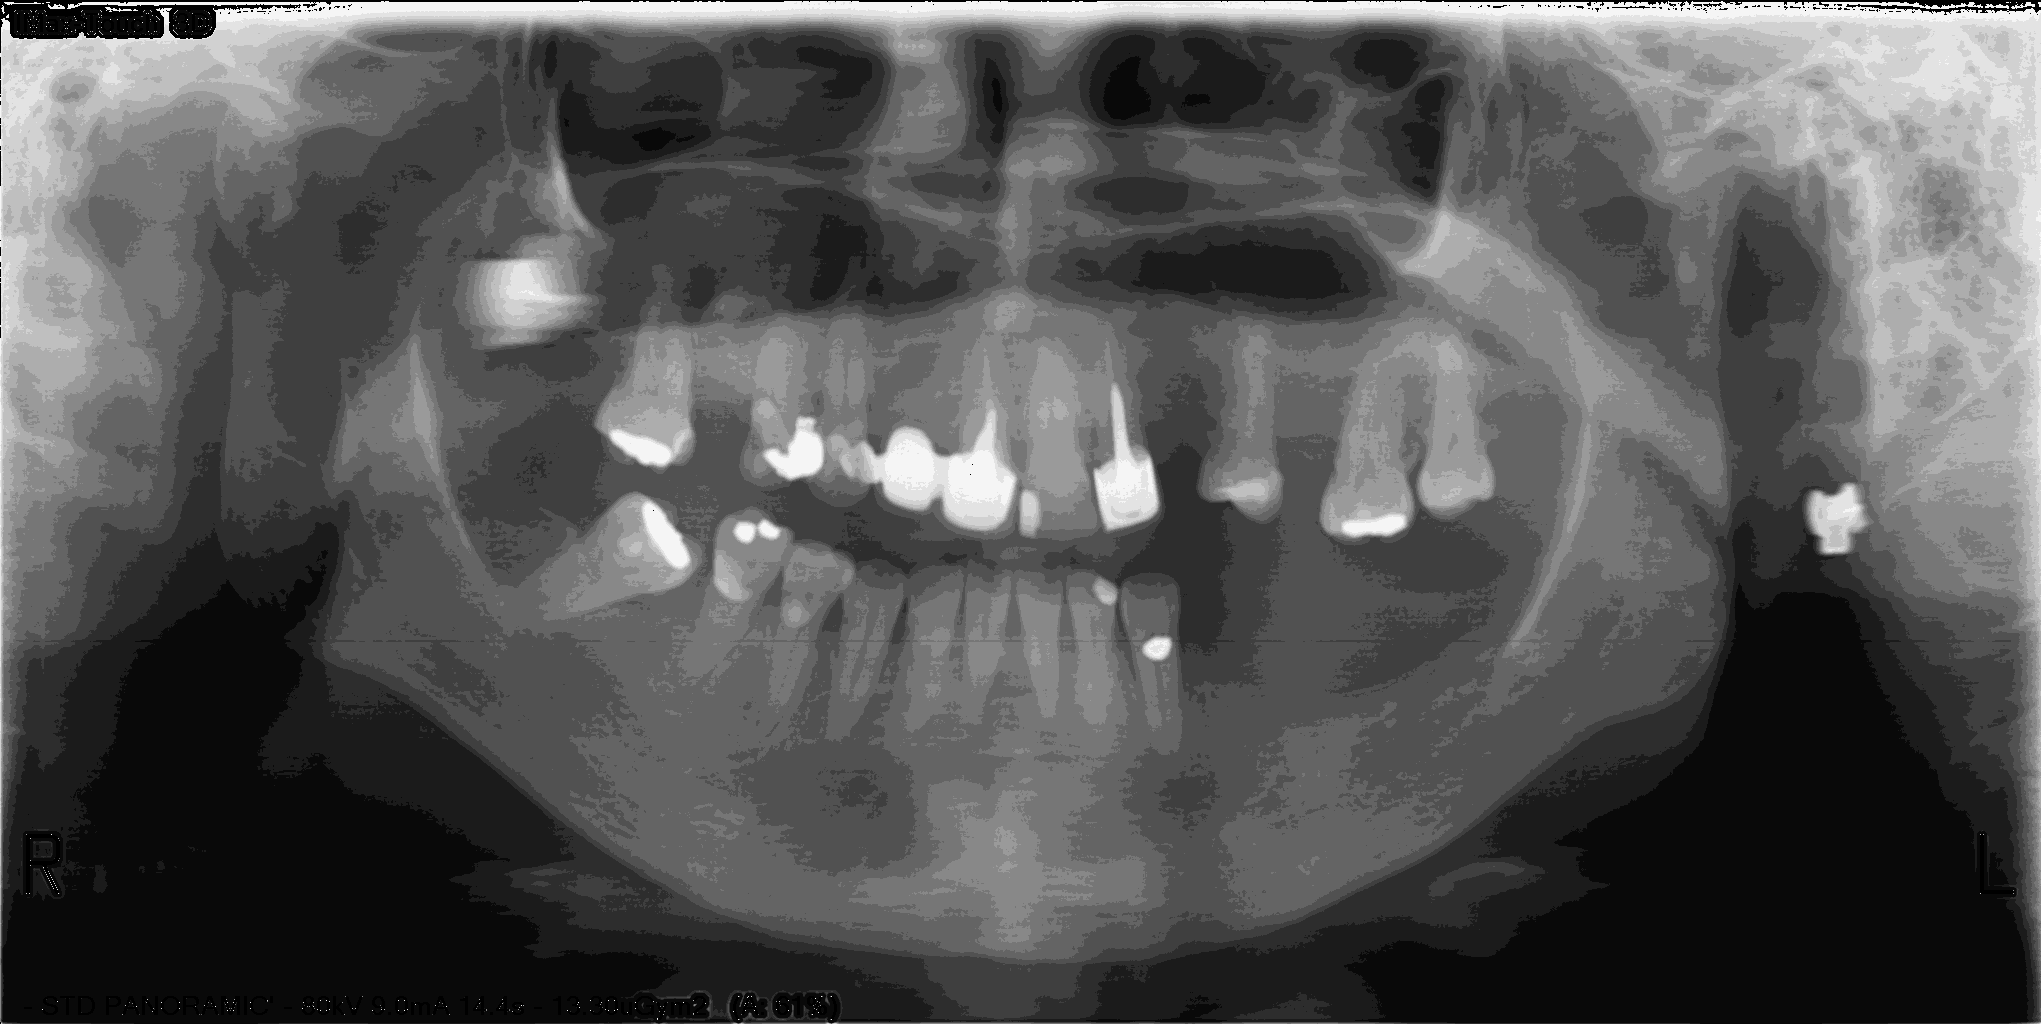

In [782]:

#* PLAYGROUND 
#! tutaj trzeba wywalic ta szczeke i taki jest caly cel
image = images_np[72]

image[image >= 250] = 0.0 # usuwanie super jasnych napisow 

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (69, 185))
# image = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)

# moze gauss dolno-przepustowy by tu wszedl
# fourier_image = to_fft(image)
# filtered_fourier = apply_gaussian_hpf(fourier_image, 0.1)
# image = from_fft(filtered_fourier)

image = thresholding(image, n=15)

Image.fromarray(image)

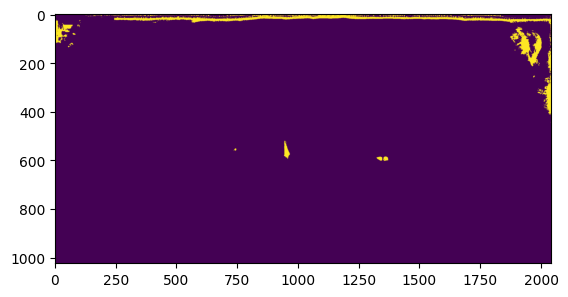

In [691]:
plt.imshow(mask_eroded)

(array([1018949.,  595162.,  260342.,   96178.,   40164.,   28066.,
          19264.,   13632.,    8411.,    9816.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

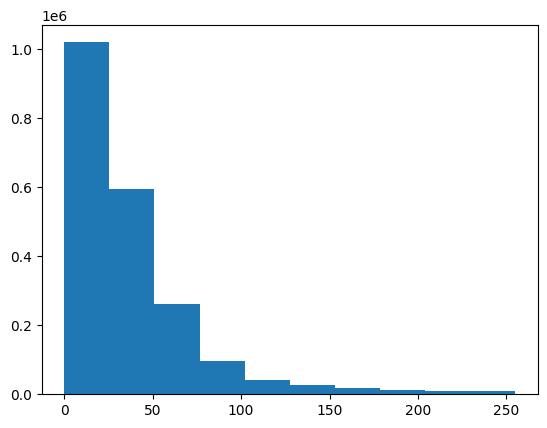

In [442]:
image = image.flatten()
plt.hist(image)

In [250]:
"""
    Transformata Fouriera to nie jest dobry pomysl - wydaje sie jakby pasowal do problemu ale tak naprawde
    Wypadaloby sprawdzic detekcje linii - brzmi to dosyc dobrze
    
"""

'\n    Transformata Fouriera to nie jest dobry pomysl - wydaje sie jakby pasowal do problemu ale tak naprawde\n'